# Recursive XOR Generalization

In one of our [introductory examples](https://github.com/LukasZahradnik/PyNeuraLogic/blob/master/examples/IntroductionIntoPyNeuraLogic.ipynb) we have showcased how to learn the XOR operation for two inputs. In this example, we will generalize the learning of the XOR operation to *N* inputs while making the use of recursion.

We will define a recursive template, train it on the classic XOR (two inputs) and show an inference of inputs of different lengths.

The template will essentially evaluate *xor_n = xor(val_n, xor_n-1)* with shared weights across all depths.

In [1]:
! pip install neuralogic

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
    --------------------------------------- 0.0/2.0 MB 487.6 kB/s eta 0:00:05
   ---- ----------------------------------- 0.2/2.0 MB 2.0 MB/s eta 0:00:01
   ------- -------------------------------- 0.4/2.0 MB 2.5 MB/s eta 0:00:01
   ----------- ---------------------------- 0.6/2.0 MB 2.9 MB/s eta 0:00:01
   --------------- ------------------------ 0.8/2.0 MB 3.2 MB/s eta 0:00:01
   ------------------ --------------------- 0.9/2.0 MB 3.1 MB/s eta 0:00:01
   ---------------------- ----------------- 1.1/2.0 MB 3.3 MB/s eta 0:00:01
   ------------------------- -------------- 1.3/2.0 MB 3.3 MB/s eta 0:00:01
   ----------------------------- ---------- 1.5/2.0 MB 3.5 MB/s eta 0:00:01
   --------------------------------- ------ 1.7/2.0 MB 3.5 MB/s eta 0:00:01
   -------------------------------------- - 1.9/2.0 MB 3.6 MB/s eta 0:00:01
   ---------------------

In [2]:
from neuralogic.nn import get_evaluator
from neuralogic.core import Settings, R, V, Template, Transformation
from neuralogic.dataset import Dataset

C:\Users\kraus\Plocha\BAK\untouched_original\PyNeuraLogic\neuralogic\core\builder\builder.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Before we define rules for the actual learning, we introduce helper relations (facts) `R._next`. Those rules serve for the definition of the sequence of integers, that is *1, 2, ..., N* (*N* is defined by `max_number_of_vars`). We have to do that because later on, we will utilize this sequence for the recursion. Integers in PyNeuraLogic are independent entities with no extra meaning or context.

In [3]:
max_number_of_vars = 5

template = Template()
template += (R._next(i, i + 1) for i in range(max_number_of_vars))

We then define the base case of the recursion, that is, to get the value of `xor` of length *1* (index *0*) return the value of the first (index *0*) element.

In [4]:
template += R.xor_at(0) <= R.val_at(0)

Now when we have the base case ready, we introduce the recursive "calls". The following rule can be interpreted as "To calculate the `xor` of length *N* (`V.Y`), calculate the xor of length *N - 1* (`V.X`) and pipe the result together with the element at index *N* (`R.val_at(V.Y)`) into `xor`".

We also assigned three unique vector learnable parameters and named them. Naming is entirely optional and is here only to show the mapping later.

In [5]:
template += R.xor_at(V.Y)["a": 1, 8] <= (R.val_at(V.Y)["b": 8, 1], R.xor_at(V.X)["c": 8, 1], R._next(V.X, V.Y))

And that is everything you need to define a template for recursive generalization of XOR!

The recursion, together with weights mapping, can be viewed in the template graph by drawing it.

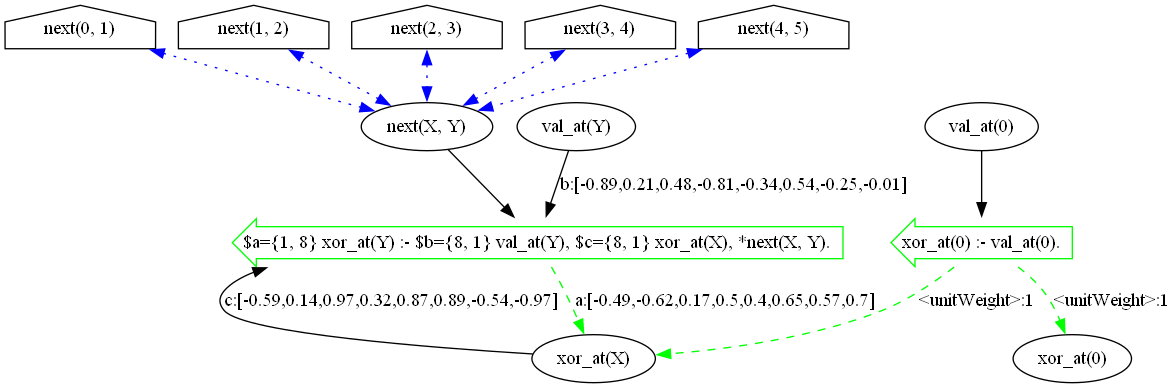

In [6]:
template.draw()

The definition of the training data set is straightforward; we train the model on inputs of the length of two. That is, we encode `xor(0, 0) -> 0`, `xor(1, 0) -> 1`, and so on as the training set.

In [7]:
examples = [
    [R.val_at(0)[0], R.val_at(1)[0]],  # input: 0, 0
    [R.val_at(0)[0], R.val_at(1)[1]],  # input: 0, 1
    [R.val_at(0)[1], R.val_at(1)[0]],  # input: 1, 0
    [R.val_at(0)[1], R.val_at(1)[1]],  # input: 1, 1
]

queries = [  # outputs: 0, 1, 1, and 0
    R.xor_at(1)[0], R.xor_at(1)[1], R.xor_at(1)[1], R.xor_at(1)[0],
]

train_dataset = Dataset(examples, queries)

TypeError: Dataset.__init__() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
settings = Settings(
    epochs=5000,
    rule_transformation=Transformation.TANH,
    relation_transformation=Transformation.IDENTITY,
    iso_value_compression=False,
)

evaluator = get_evaluator(template, settings)
built_dataset = evaluator.build_dataset(train_dataset)

Notice we turned off compression, so the recursion is clearly visible in the visual representation later on.

Once we build the training dataset, we can visualize each sample. For example, the `xor(0, 0)` sample will be represented by the following computation graph.

In [ ]:
built_dataset.samples[0].draw()

In [ ]:
evaluator.train(built_dataset, generator=False)

We train the model on the training dataset via the evaluator and prepare a test dataset. We can put into the dataset any input of maximum length of *N* (`max_number_of_vars`). For this example, we chose `xor(0, 0, 1)` and `xor(1, 0, 1, 0)`. Feel free to try out other lengths and combinations!

In [ ]:
test_examples = [
    [R.val_at(0)[0], R.val_at(1)[0], R.val_at(2)[1]],
    [R.val_at(0)[1], R.val_at(1)[0], R.val_at(2)[1], R.val_at(3)[0]],
]

test_queries = [
    R.xor_at(2), R.xor_at(3)
]

test_dataset = Dataset(test_examples, test_queries)
built_test_dataset = evaluator.build_dataset(test_dataset)

When we visualize our test samples and compare them, we can clearly see how the template is recursively unrolled into computation graphs (trees) with shared weights across depths.

In [ ]:
built_test_dataset.samples[0].draw()

In [ ]:
built_test_dataset.samples[1].draw()

Running inference on our test dataset yields correct results, that is `xor(0, 0, 1) = 1` and `xor(1, 0, 1, 0) = 0`. 

In [ ]:
for result in evaluator.test(built_test_dataset):
    print(result)